In [1]:
# Autoreload 
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# Bacis libraries #
import os
import sys
import math
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

# Pytorch #
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Lightning #
import lightning as L
from lightning.pytorch.callbacks import EarlyStopping, ModelCheckpoint
from lightning.pytorch.loggers import CometLogger
from datetime import datetime

# Personal scripts #
path_src = '../src'
if path_src not in sys.path:
    sys.path.insert(0,path_src)
from preprocessing import *
from callbacks import *
from transformer import AnalysisObjectTransformer, Embedding
from losses import BCEDecorrelatedLoss, MulticlassDecorrelatedLoss # added Loss for multiclassifier
from plotting import plot_roc, plot_confusion_matrix


torch.set_float32_matmul_precision('medium')
accelerator = 'gpu' if torch.cuda.is_available() else "cpu"
print (f"Accelerator : {accelerator}")

Accelerator : gpu


# Import datasets

Our files are in parquet files : one for each process, containing all the event level information

The following lines do the import into a pandas dataframe, and the different preprocessing steps we need (remove negative weight events, make labls, split into training and validation sets, etc)

In [2]:
# Make output directory #
current_time = datetime.now().strftime("%Y%m%d_%H%M%S")
outdir = f"./model_training/AOTransformer_{current_time}"
os.makedirs(outdir, exist_ok=False)

## Specify dataset files to run over ##
path = "/cephfs/dice/projects/CMS/Hinv/ml_datasets_ul_241111/ml_inputs_UL{year}/{dataset}.parquet" #newer datasets

datasets = [
    #Signal events
    'ttH_HToInvisible_M125',

    #ttbar events
    'TTToSemiLeptonic',
    'TTTo2L2Nu',
    'TTToHadronic',

    #ZJetsToNuNu events
    'ZJetsToNuNu_HT-100To200',
    'ZJetsToNuNu_HT-200To400',
    'ZJetsToNuNu_HT-400To600',
    'ZJetsToNuNu_HT-600To800',
    'ZJetsToNuNu_HT-800To1200',
    'ZJetsToNuNu_HT-1200To2500',
    'ZJetsToNuNu_HT-2500ToInf',

    #WJetsToLNu events
    'WJetsToLNu_HT-100To200',
    'WJetsToLNu_HT-200To400',
    'WJetsToLNu_HT-400To600',
    'WJetsToLNu_HT-600To800',
    'WJetsToLNu_HT-800To1200',
    'WJetsToLNu_HT-1200To2500',
    'WJetsToLNu_HT-2500ToInf',
]

##### Other background data to focus on: ######
    #-QCD
    #-Multiboson -WW<ZZ,ZW,WWW,ZZZ,WZZ,WWZ
    #-ttZtoleptons,ttWtoleptons



years = ['2018']

files = [
    path.format(year=year, dataset=dataset)
    for dataset in datasets
    for year in years
]

## Data preprocessing ##
df = load_from_parquet(files)
df = remove_negative_events(df)

#For multiclassification (3 BG), we set 4 targets:
# Signal is 0
# First BG is 1
# Second BG is 2
# Third BG is 3

#use multiclass labelling
df["target"] = create_multiclass_labels(df["dataset"])  #Signal
#df["target"] = create_target_labels(df["dataset"])


#apply multiclass weighting
apply_reweighting_per_class_multiclass(df) #change this for multiclassification

reweighting = torch.Tensor(df['weight_training'].values)



## WE NEED TO TRACK weight_nominal ##
#weight_nominal is used to reweight the events to the same cross section, but it is not used in the training
weight_nominal_values = df['weight_nominal'].values
weight_nominal_tensor = torch.Tensor(weight_nominal_values)
###





# This converts the awkward array to a tensor
X, y, pad_mask = awkward_to_inputs_parallel_multiclass(df, n_processes=8, target_length=10)

#event level is used to split the dataset into events, so that events are not split between training and validation
event_level = get_event_level(df)
#split_masks = kfold_split(df, k=2)      # returns a list with a mask for each fold, so if only training one select it in line below
#split = split_masks[0]

## Create training datasets ##
##We add the weight_nominal to the training dataset
train_X, val_X, train_y, val_y, train_weights, val_weights, train_mask, val_mask, train_event, val_event, train_weight_nominal,val_weight_nominal = train_test_split(
    X, 
    y, 
    reweighting, 
    pad_mask, 
    event_level, 
    weight_nominal_tensor,
    test_size=0.2,  
    random_state=42,
)


#the training and validation datasets are created. 
# We don't need the weight_nominal here
train_dataset = TensorDataset(train_X, train_y, train_weights, train_mask, train_event)
valid_dataset = TensorDataset(val_X, val_y, val_weights, val_mask, val_event)

## Create loaders ##
batch_size = 1024

train_loader = DataLoader(
    dataset = train_dataset, 
    batch_size = batch_size, 
    shuffle = True, 
)
valid_loader = DataLoader(
    dataset = valid_dataset, 
    batch_size = 10000, # can use larger batches for the GPU 
    shuffle = False, 
    #num_workers = 20,
)
# NOTE : in a jupyter notebook it is not possible to use `num_workers` dues to multiprocessing issues.
# Use this notebook for testing and experimenting, but to benefit from multiprocessing batch loading, you will need the python scripts

2025-02-18 13:28:32,070 - INFO - Loading data from 18 parquet files...
2025-02-18 13:28:32,071 - INFO - Reading file: /cephfs/dice/projects/CMS/Hinv/ml_datasets_ul_241111/ml_inputs_UL2018/ttH_HToInvisible_M125.parquet
2025-02-18 13:28:34,502 - INFO - /cephfs/dice/projects/CMS/Hinv/ml_datasets_ul_241111/ml_inputs_UL2018/ttH_HToInvisible_M125.parquet contains 257876 events
2025-02-18 13:28:34,644 - INFO - Filtered df contains 240373 events from regions [0, 6]
2025-02-18 13:28:34,747 - INFO - Reading file: /cephfs/dice/projects/CMS/Hinv/ml_datasets_ul_241111/ml_inputs_UL2018/TTToSemiLeptonic.parquet
2025-02-18 13:28:55,810 - INFO - /cephfs/dice/projects/CMS/Hinv/ml_datasets_ul_241111/ml_inputs_UL2018/TTToSemiLeptonic.parquet contains 2372446 events
2025-02-18 13:28:56,849 - INFO - Filtered df contains 1297663 events from regions [0, 6]
2025-02-18 13:28:59,459 - INFO - Reading file: /cephfs/dice/projects/CMS/Hinv/ml_datasets_ul_241111/ml_inputs_UL2018/TTTo2L2Nu.parquet
2025-02-18 13:29:02,

# Input plots 

Always a good idea to check the inputs you provide in the training. It is very easy to introduce incorrect data in the training, and then spend hours investigating the problem in the model, only to find the data is nonsensical (the good old "garbage in, garbage out" syndrom).

The plotting scripts below show the inputs features (ie, jet features) as a function of the multiplicity and labels.
- var 0 : $p_T$
- var 1 : $\eta$
- var 2 : $\phi$
- var 3 : mass
- var 4 : area


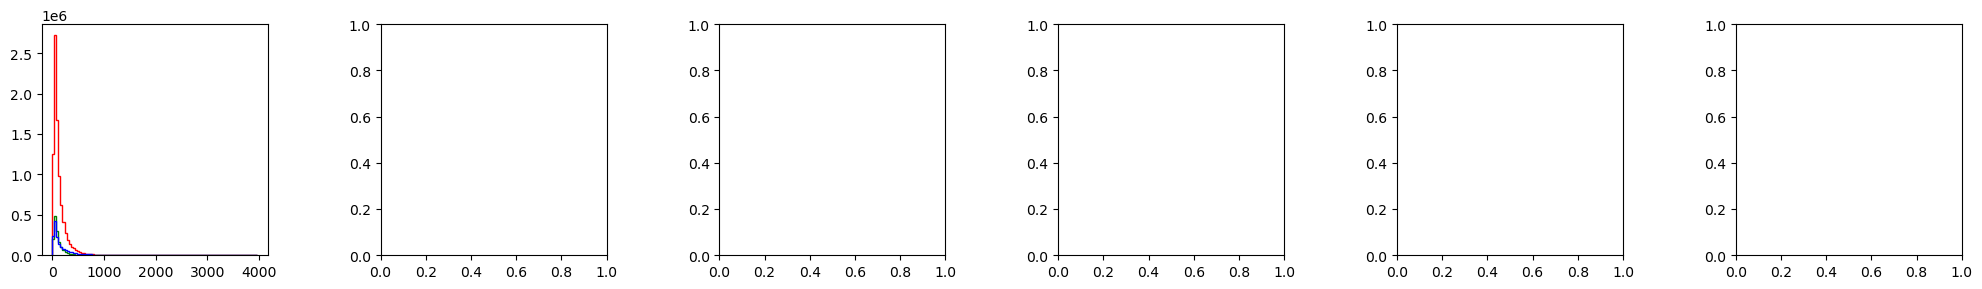

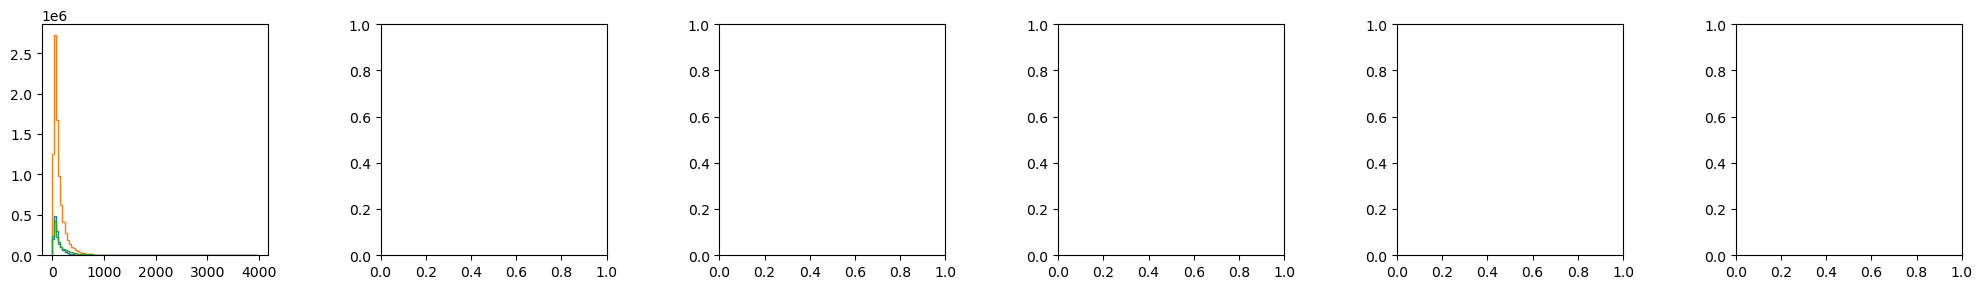

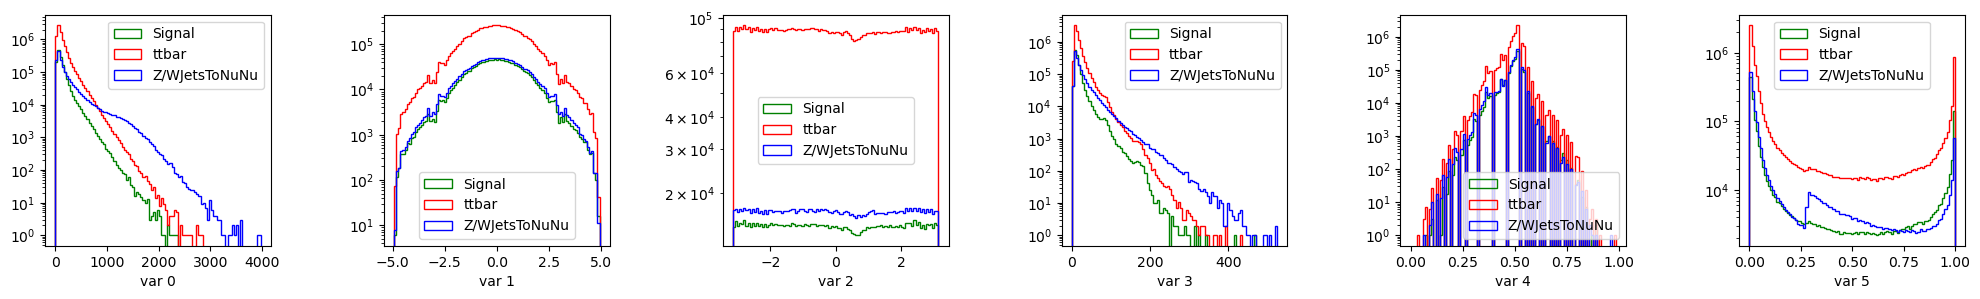

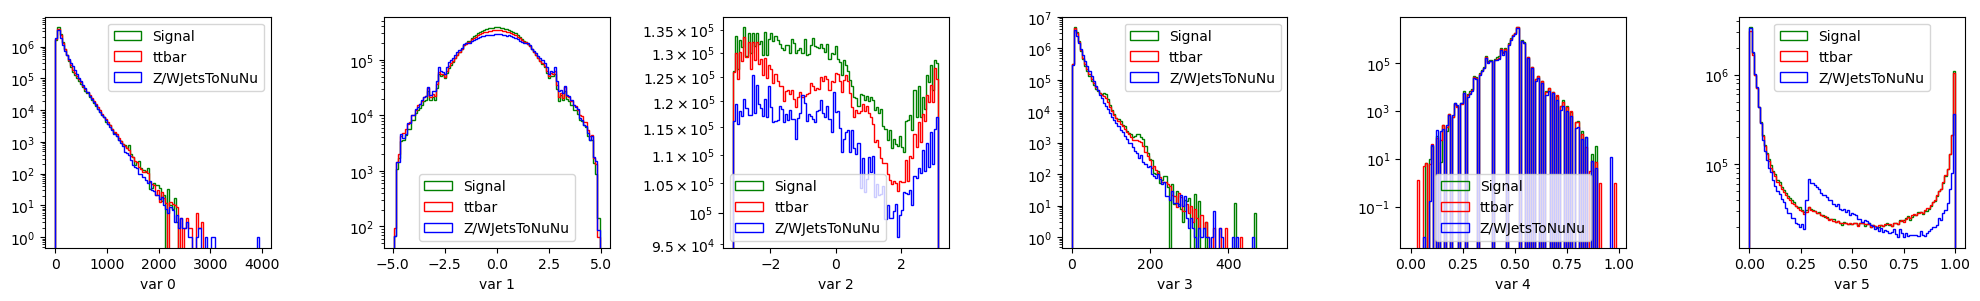

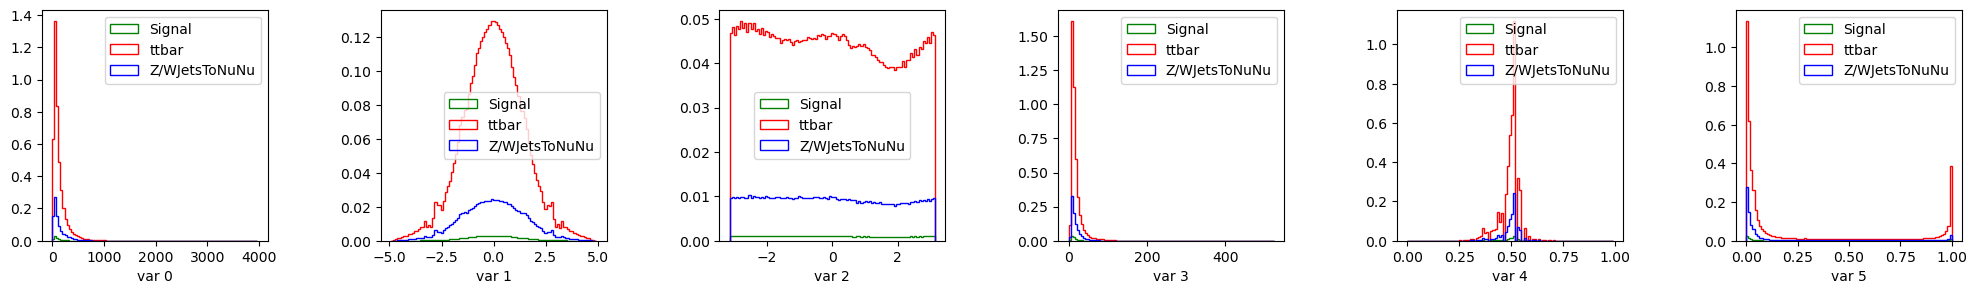

In [5]:
# fig = plot_inputs_per_multiplicity(X,y,pad_mask,bins=100,log=True,show=True)
# fig = plot_inputs_per_label(X,y,pad_mask,bins=100,log=True,show=True)
# fig = plot_inputs_per_label(X,y,pad_mask,bins=100,weights=reweighting,log=True,show=True)

###MULTICLASSIFICATION###
#make a new plot_inputs_per_label function for multiclassification.

fig = plot_inputs_per_label_multiclassification(X, y, pad_mask, bins=100, log=True, show=True)
fig = plot_inputs_per_label_multiclassification(X, y, pad_mask, bins=100, weights=reweighting, log=True, show=True)
fig = plot_inputs_per_label_multiclassification(X, y, pad_mask, bins=100, weights=weight_nominal_tensor, log=False, show=True)


In [ ]:
# fig = plot_inputs_per_label(X,y,pad_mask,bins=100,weights=weight_nominal_tensor,log=False,show=True)
# fig = plot_inputs_per_label(X,y,pad_mask,bins=100,weights=weight_nominal_tensor,log=True,show=True)

# Model
The transformer model can be tweaked with the parameters below (see explanations for each parameter.

The loss function is a composite of BCE, and decorrelation from the MET, to ensure the transformer does not sculpt the latter.

In [6]:
import torch.nn.functional as F

# Define model #

########
#MULTICLASSIFICATION: CrossEntropyLoss??
########



#loss_function = BCEDecorrelatedLoss(lam = 0.1,weighted=True)
# loss = BCE + lambda * decorrelated loss 
# lambda = 0 -> pure BCE
loss_function = MulticlassDecorrelatedLoss(lam=0.1, weighted=True)


# Embedding of the jet features into a higher dimension
embedding = Embedding(
    input_dim = train_X.shape[-1],   # Input dimension
    embed_dims = [64],               # Output dimension
    normalize_input = True,          # Whether to apply batch norm before the embedding
)


#LAYERS:
#Play around with the number of encoder layers, class layers and dnn layers.

model = AnalysisObjectTransformer(
    embedding = embedding,           # Embedding instance
    embed_dim = embedding.dim,       # Embedding dimension
    num_heads = 8,                   # Number of heads for multihead attention (must be a divisor of embed dim)
    output_dim = 4,                  # Output dimension (1 : binary classification, >1 : multi classification) - 4 for multiclass
    expansion_factor = 4,            # Multipliying factor for layers in attention block (neurons = embed_dim * expansion_factor)
    encoder_layers = 4,              # Number of encoder layers (self attention on jets)
    class_layers = 2,                # Number of class layers (cross attention between jets representations and class token)
    dnn_layers = 3,                  # Number of layers for DNN after the transformer (most of heavy lifting done by trnasformer, dont need >3)
    hidden_activation = nn.GELU,     # Hidden activation in transformer and DNN
    output_activation = None,        # DNN output activation (sigmoid for binary, softmax for multiclass, None if applied in the loss)
    dropout = 0.25,                  # Dropout rate
    loss_function = loss_function,   # Loss function, see above
)

# Print the model graph #
print (model)
# Quick benchmark test the model #
# To make sure the model will run, we take a single batch from the training and pass it through the model

batch = next(iter(train_loader))

inputs, labels, weights, mask, event = batch
print ('Batch dtypes',inputs.dtype,labels.dtype,weights.dtype,mask.dtype,event.dtype)

outputs = model(inputs,padding_mask=mask)
print ('outputs',outputs .shape)
loss_values = loss_function(outputs,labels,event,weights)
print ('losses',loss_values)

AnalysisObjectTransformer(
  (embedding): Embedding(
    (input_bn): BatchNorm1d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (layers): Sequential(
      (0): Linear(in_features=6, out_features=64, bias=True)
      (1): GELU(approximate='none')
    )
  )
  (encoder_blocks): ModuleList(
    (0-3): 4 x AttBlock(
      (layer_norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (multihead_attention): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
      )
      (layer_norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (layer_norm3): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (linear1): Linear(in_features=64, out_features=256, bias=True)
      (activation): GELU(approximate='none')
      (layer_norm4): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (linear2): Linear(in_features=256, out_features=64, bias=True)
    )
  )
  (class_blocks): M

# Training 

Writing the training loop can involve a biut of boilerplate code. To bypass that we use the [pytorch-lightning](https://lightning.ai/docs/pytorch/stable/) package to run the training. 

The batch steps were defined in the model class, and now we can use the trainer class from lightning to run the training. This takes care of doing the loop, putting data on the GPU if needed, applying the schedule, etc.

One way to finetune our training (or monitor it) is through callbacks. Callbacks are class objects that are evaluated at different times during the training, and allow the user to access their model. Below we use a few of those :
- model checkpoint : saves the best model parameters at every epoch
- early stopping : if the loss values (of the validation) plateau, stops the training (hopefully before overtraining)
- plotting : a plotting callback we wrote to plot the classification metrics at every epoch
- a few other tweaks

Lighting also allows several plotter interface, we use `comet` to log all our metrics (and callback plots) online. You will need an account [here](https://www.comet.com/signup), you can use your github account if you want.

In [7]:
##### Parameters #####
epochs = 100 #was 500
lr = 1e-4

steps_per_epoch_train = math.ceil(len(train_dataset)/train_loader.batch_size)
steps_per_epoch_valid = math.ceil(len(valid_dataset)/valid_loader.batch_size)

print (f'Training   : Batch size = {train_loader.batch_size} => {steps_per_epoch_train} steps per epoch')
print (f'Validation : Batch size = {valid_loader.batch_size} => {steps_per_epoch_valid} steps per epoch')

# Setup optimizer #
optimizer = optim.Adam(model.parameters(), lr=lr)
model.set_optimizer(optimizer)

# Setup scheduler #
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
   optimizer = optimizer,
   mode = 'min', 
   factor = 0.5, 
   patience = 6,               #reduce the learning rate after 10 epochs without improvement
   threshold = 0.,              #threshold for measuring the new optimum
   threshold_mode = 'rel', 
   cooldown = 0, 
   min_lr = 1e-8,               #minimum learning rate
)

model.set_scheduler_config(
    {
        'scheduler' : scheduler,
        'interval' : 'step' if isinstance(scheduler,optim.lr_scheduler.OneCycleLR) else 'epoch',
        'frequency' : 1,
        'monitor' : 'val/loss_tot',
        'strict' : True,
        'name' : 'lr',
    }
)

# Setup callbacks #
checkpoint_callback = ModelCheckpoint(
    dirpath=outdir,  # Directory where checkpoints will be saved
    filename="best-checkpoint",  # Checkpoint filename
    monitor="val/loss_tot",  # Monitor validation loss
    mode="min",  # Save the best model with the minimum validation loss
    save_top_k=1  # Save only the best model
)

early_stopping = EarlyStopping(
    monitor='val/loss_tot',  # Metric to monitor
    patience=10,          # Number of epochs with no improvement after which training will be stopped
    verbose=True,
    mode='min'           # 'min' for loss, 'max' for accuracy
)

log_bar = L.pytorch.callbacks.TQDMProgressBar(refresh_rate=steps_per_epoch_train//100)

plots_callback = EpochEndCallback_Multiclass(
    data = valid_loader,
    frequency = 1,
    subcallbacks = [
        #ScoreSubCallback_Multiclass(name='score',bins=100,log=True),
        #CorrelationSubCallback(name='corr',bins=100,log=True),
        ROCSubCallback_Multiclass(name='ROC'),
        #ConfusionMatrixSubCallback_Multiclass(name='CM'),
    ]
)

## Logger ##
##Commented out for now to avoid large comet log files

logger = CometLogger(
    api_key = os.environ.get("COMET_API_KEY"),
    project_name = "AnalysisObjectTransformer",
    experiment_name = "Setup",
    save_dir = "./comet_logs",  # Specify where to save Comet logs if offline
    offline = False  # Set to True for offline mode
)

## Trainer ##
trainer = L.Trainer(
    default_root_dir = outdir,
    accelerator = accelerator,
    devices = [2], # Number of GPUs. Notebook only supports 1
    max_epochs = epochs,  # Specify the number of epochs
    log_every_n_steps = steps_per_epoch_train,
    check_val_every_n_epoch = 1,  # Check validation every n epochs
    callbacks = [
        checkpoint_callback, 
        early_stopping,
        log_bar,
        plots_callback,
    ],
    logger = logger,
    # limit_train_batches = 10,
    # limit_val_batches = 1,
    # limit_test_batches = 1,
)

trainer.fit(
    model = model, 
    train_dataloaders = train_loader, 
    val_dataloaders = valid_loader,
)

trainer.save_checkpoint(f"{outdir}/model.pt")

CometLogger will be initialized in offline mode


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch, sklearn.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
/software/da21592/miniconda3/envs/hinv-ml/lib/python3.12/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:652: Checkpoint directory /users/da21592/msci_project/transformer_renewed/bristol-tth-transformer-msc_project/notebooks/model_training/AOTransformer_20250217_195245 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5]

  | Name           | Type                       | Params | Mode 
----------------------------------------------------------------------
0 | embedding      | Embedding                  | 460    | train
1 | encoder_blocks | ModuleList  

Training   : Batch size = 1024 => 1561 steps per epoch
Validation : Batch size = 10000 => 40 steps per epoch


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/software/da21592/miniconda3/envs/hinv-ml/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=47` in the `DataLoader` to improve performance.
/software/da21592/miniconda3/envs/hinv-ml/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=47` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

/software/da21592/miniconda3/envs/hinv-ml/lib/python3.12/site-packages/lightning/pytorch/trainer/call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml OfflineExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     name                  : Setup
COMET INFO:     url                   : [OfflineExperiment will get URL after upload]
COMET INFO:   Others:
COMET INFO:     Created from       : pytorch-lightning
COMET INFO:     Name               : Setup
COMET INFO:     offline_experiment : True
COMET INFO:   Uploads:
COMET INFO:     conda-environment-definition : 1
COMET INFO:     conda-info                   : 1
COMET INFO:     conda-specification          : 1
COMET INFO:     environment details          : 1
COMET INF

### Load Checkpoint Here

- Run everything from start, skipping trainer cell, then run the below cells.

In [7]:
# Load the best checkpoint
checkpoint_path = f"./model_training/AOTransformer_20250217_195245/model.pt" #2BG, ttbar and W/ZJets, ~45epochs, regions [0,6]

loss_function = MulticlassDecorrelatedLoss(lam=0.1, weighted=True)

# First recreate embedding with same configuration
# Embedding of the jet features into a higher dimension
# embedding = Embedding(
#     input_dim = 6,                  # Input dimension
#     embed_dims = [64],               # Output dimension
#     normalize_input = True,          # Whether to apply batch norm before the embedding
# )

# Now load the checkpoint
model = AnalysisObjectTransformer.load_from_checkpoint(
    checkpoint_path,
    embedding=embedding,
    embed_dim=embedding.dim,
    num_heads=8,
    output_dim=4,  # Match checkpoint's output dimension
    expansion_factor=4,
    encoder_layers=4,
    class_layers=2,
    dnn_layers=3,
    hidden_activation=nn.GELU,
    output_activation=None,
    dropout=0.25,
    loss_function=loss_function
)

# Set model to evaluation mode
model.eval()




/software/da21592/miniconda3/envs/hinv-ml/lib/python3.12/site-packages/lightning/fabric/utilities/cloud_io.py:57: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.


AnalysisObjectTransformer(
  (embedding): Embedding(
    (input_bn): BatchNorm1d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (layers): Sequential(
      (0): Linear(in_features=6, out_features=64, bias=True)
      (1): GELU(approximate='none')
    )
  )
  (encoder_blocks): ModuleList(
    (0-3): 4 x AttBlock(
      (layer_norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (multihead_attention): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
      )
      (layer_norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (layer_norm3): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (linear1): Linear(in_features=64, out_features=256, bias=True)
      (activation): GELU(approximate='none')
      (layer_norm4): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (linear2): Linear(in_features=256, out_features=64, bias=True)
    )
  )
  (class_blocks): M

In [10]:
import lightning as L

# Create a minimal trainer for prediction only
trainer = L.Trainer(accelerator=accelerator, devices=[2])

preds = trainer.predict(model=model, dataloaders=valid_loader)
preds = torch.cat(preds, dim=0)
probs = F.softmax(preds, dim=1)  # Convert to probabilities

# Get data
inputs, labels, weights, mask, event = valid_dataset.tensors

# Get predicted classes
pred_classes = torch.argmax(probs, dim=1)

# Calculate accuracy per class
for i in range(3):
    mask_i = labels == i
    acc_i = (pred_classes[mask_i] == labels[mask_i]).float().mean()
    print(f"Class {i} accuracy: {acc_i:.3f}")

# Overall accuracy
acc = (pred_classes == labels).float().mean()
print(f"\nOverall accuracy: {acc:.3f}")

print(f"\nPredictions shape: {preds.shape}")  # Should show 4 classes in second dimension

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/software/da21592/miniconda3/envs/hinv-ml/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/logger_connector/logger_connector.py:75: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
Missing logger folder: /users/da21592/msci_project/transformer_renewed/bristol-tth-transformer-msc_project/notebooks/lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5]
/software/da21592/miniconda3/envs/hinv-ml/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'predict_d

Predicting: |          | 0/? [00:00<?, ?it/s]

Class 0 accuracy: 0.627
Class 1 accuracy: 0.653
Class 2 accuracy: 0.729

Overall accuracy: 0.661

Predictions shape: torch.Size([399567, 4])


In [11]:
# ## Testing model performance on validation set ##




## Testing model performance on validation set ##
preds = trainer.predict(model=model, dataloaders=valid_loader)
preds = torch.cat(preds, dim=0)
probs = F.softmax(preds, dim=1)  # Convert to probabilities

# Get data
inputs, labels, weights, mask, event = valid_dataset.tensors

# Get predicted classes
pred_classes = torch.argmax(probs, dim=1)

# Calculate accuracy per class
for i in range(3):
    mask_i = labels == i
    acc_i = (pred_classes[mask_i] == labels[mask_i]).float().mean()
    print(f"Class {i} accuracy: {acc_i:.3f}")

# Overall accuracy
acc = (pred_classes == labels).float().mean()
print(f"\nOverall accuracy: {acc:.3f}")

print(f"\nPredictions shape: {preds.shape}")  # Should show 3 classes in second dimension

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5]


Predicting: |          | 0/? [00:00<?, ?it/s]

Class 0 accuracy: 0.627
Class 1 accuracy: 0.653
Class 2 accuracy: 0.729

Overall accuracy: 0.661

Predictions shape: torch.Size([399567, 4])


In [12]:
labels.shape,preds.shape

(torch.Size([399567]), torch.Size([399567, 4]))

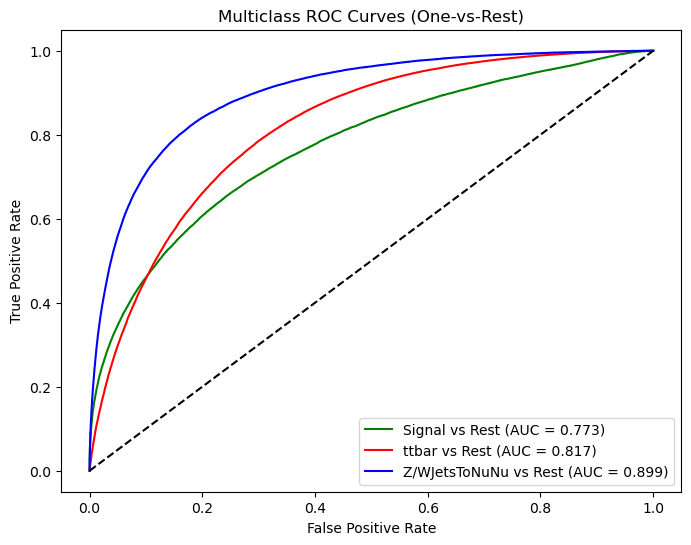

In [22]:
# Plot multiclass ROC curves
fig = plot_multiclass_roc(labels, probs, outdir=outdir, show=True)


# PLotting Significance (Z-Score) 


No systematic:
Max significance: 6.28
At threshold: 0.960
S: 42.0
B: 44.9

5% systematic:
Max significance: 5.95
At threshold: 0.960
S: 42.0
B: 44.9

10% systematic:
Max significance: 5.37
At threshold: 0.980
S: 26.4
B: 20.1


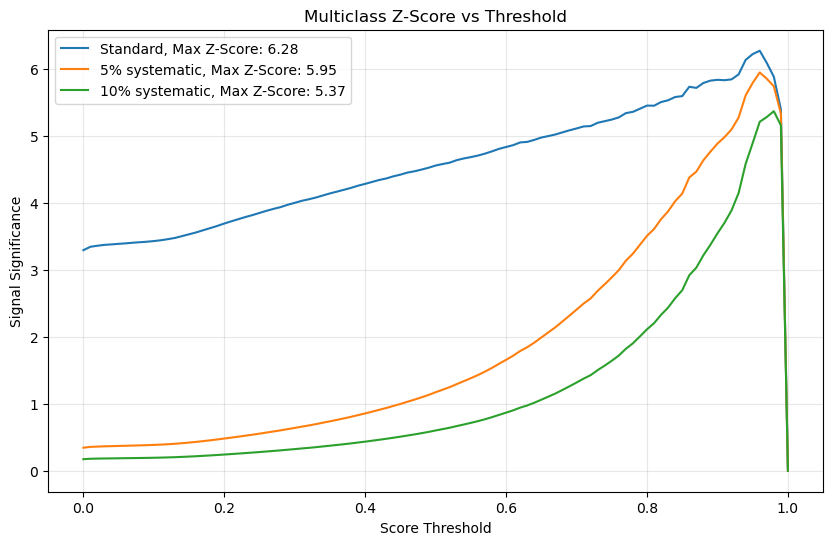

In [24]:
import numpy as np
import torch
import matplotlib.pyplot as plt

# Convert model outputs to probabilities for each class using softmax (preds.shape => [N, 3])
# Assuming preds[:, 0] corresponds to signal probability
pred_probs = torch.softmax(preds, dim=1).detach().cpu().numpy()  # shape (N,3)

# For Z-score calculation, use probability of signal (class=0)
signal_scores = pred_probs[:, 0]

# Ground truth: 0 => signal, 1 or 2 => background
truth = labels.detach().cpu().numpy().flatten()
# Weigh events (example: multiply nominal weights by 2e5 for convenience)
event_weights_np = val_weight_nominal.clone().detach().cpu().numpy().flatten() * 200000

# Prepare thresholds
thresh_points = np.linspace(0, 1, 101)
significance_0 = []
significance_5 = []
significance_10 = []

for cut in thresh_points:
    # Events passing threshold
    signal_mask = (signal_scores > cut) & (truth == 0)
    bkg_mask = (signal_scores > cut) & (truth != 0)
    
    # Weighted S and B
    S = np.sum(event_weights_np[signal_mask])
    B = np.sum(event_weights_np[bkg_mask])
    
    if S > 2 and B > 2:
        significance_0.append(S / np.sqrt(B))
        significance_5.append(S / np.sqrt(B + (0.05 * B) ** 2))
        significance_10.append(S / np.sqrt(B + (0.10 * B) ** 2))
    else:
        significance_0.append(0)
        significance_5.append(0)
        significance_10.append(0)

# Find max significance & thresholds
max_0 = np.max(significance_0)
max_5 = np.max(significance_5)
max_10 = np.max(significance_10)

idx_0 = np.argmax(significance_0)
idx_5 = np.argmax(significance_5)
idx_10 = np.argmax(significance_10)

thresh_0 = thresh_points[idx_0]
thresh_5 = thresh_points[idx_5]
thresh_10 = thresh_points[idx_10]

# Print info at these thresholds
for thresh_val, sig, label in zip(
    [thresh_0, thresh_5, thresh_10],
    [max_0, max_5, max_10],
    ['No systematic', '5% systematic', '10% systematic']
):
    signal_mask = (signal_scores > thresh_val) & (truth == 0)
    bkg_mask = (signal_scores > thresh_val) & (truth != 0)
    S = np.sum(event_weights_np[signal_mask])
    B = np.sum(event_weights_np[bkg_mask])
    
    print(f"\n{label}:")
    print(f"Max significance: {sig:.2f}")
    print(f"At threshold: {thresh_val:.3f}")
    print(f"S: {S:.1f}")
    print(f"B: {B:.1f}")

# Plot
plt.figure(figsize=(10,6))
plt.plot(thresh_points, significance_0, label=f'Standard, Max Z-Score: {max_0:.2f}')
plt.plot(thresh_points, significance_5, label=f'5% systematic, Max Z-Score: {max_5:.2f}')
plt.plot(thresh_points, significance_10, label=f'10% systematic, Max Z-Score: {max_10:.2f}')

plt.xlabel('Score Threshold')
plt.ylabel('Signal Significance')
plt.title('Multiclass Z-Score vs Threshold')
plt.grid(alpha=0.3)
plt.legend(loc='upper left')
plt.show()

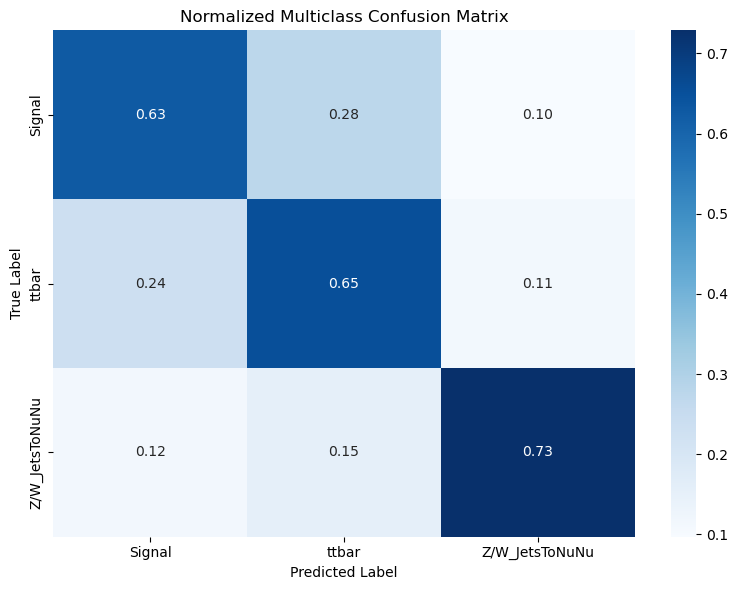

In [16]:
# # filepath: /home/da21592/msci_project/transformer_renewed/bristol-tth-transformer-msc_project/notebooks/training_multiclassification.ipynb

import torch
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# After training, switch model to eval mode
model.eval()

all_preds = []
all_labels = []

# Gather predictions and labels from validation set
with torch.no_grad():
    for inputs, labels, weights, mask, event in valid_loader:
        outputs = model(inputs, padding_mask=mask)
        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Define class labels
class_names = ['Signal', 'ttbar', 'Z/W_JetsToNuNu']

# Generate normalized confusion matrix
cf_matrix = confusion_matrix(all_labels, all_preds, labels=[0, 1, 2], normalize='true')

plt.figure(figsize=(8,6))  # Increased figure size for 4x4 matrix
sns.heatmap(cf_matrix, 
            annot=True, 
            cmap='Blues', 
            fmt='.2f',
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Normalized Multiclass Confusion Matrix')
plt.tight_layout()
plt.show()

### Fix the prediction plots below:

Predictions shape: (399567, 4)
Labels shape: (399567,)
Weights shape: (399567,)


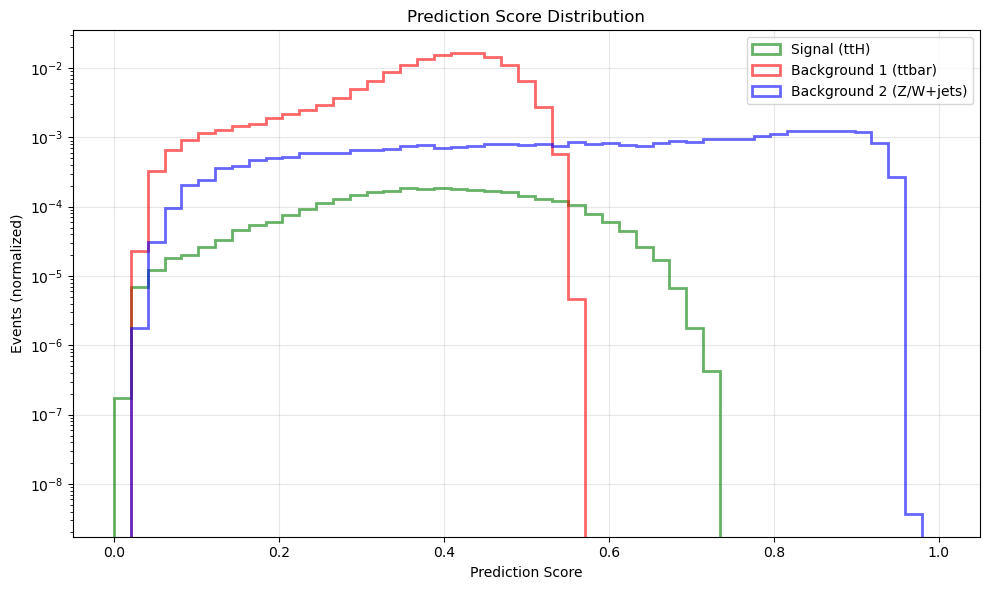

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Get predictions and convert to numpy
pred_probs = probs.detach().cpu().numpy()
labels_np = labels.detach().cpu().numpy()
weights_np = val_weight_nominal.detach().cpu().numpy()

# Print shapes for debugging
print(f"Predictions shape: {pred_probs.shape}")
print(f"Labels shape: {labels_np.shape}")
print(f"Weights shape: {weights_np.shape}")

# Create figure
plt.figure(figsize=(10,6))

# Define bins and class properties
bins = np.linspace(0, 1, 50)
class_names = ['Signal (ttH)', 'Background 1 (ttbar)', 'Background 2 (Z/W+jets)']
colors = ['g', 'r', 'b']  # One color per class

# Plot histograms for each class
for i in range(3):  # Loop over 3 classes 
    class_mask = (labels_np == i)
    class_scores = pred_probs[class_mask, i]
    class_weights = weights_np[class_mask]
    
    plt.hist(class_scores,
             bins=bins,
             weights=class_weights,
             alpha=0.6,
             color=colors[i],
             label=f'{class_names[i]}',
             density=False,
             histtype='step',
             linewidth=2)

plt.xlabel('Prediction Score')
plt.ylabel('Events (normalized)')
plt.yscale('log')
plt.title('Prediction Score Distribution')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [17]:
import numpy as np
import matplotlib.pyplot as plt

# Get predictions and convert to numpy
pred_probs = probs.detach().cpu().numpy()
labels_np = labels.detach().cpu().numpy()
weights_np = val_weight_nominal.detach().cpu().numpy()

# Print shapes for debugging
print(f"Predictions shape: {pred_probs.shape}")
print(f"Labels shape: {labels_np.shape}")
print(f"Weights shape: {weights_np.shape}")

# Create figure
plt.figure(figsize=(10,6))

# Define bins and class properties
bins = np.linspace(0, 1, 50)
class_names = ['Signal (ttH)', 'Background 1 (ttbar)', 'Background 2 (Z/W+jets)']
colors = ['g', 'r', 'b']  # One color per class

# Plot histograms for each class
for i in range(3):  # Loop over 3 classes 
    class_mask = (labels_np == i)
    class_scores = pred_probs[class_mask, i]
    class_weights = weights_np[class_mask]
    
    plt.hist(class_scores,
             bins=bins,
             weights=class_weights,
             alpha=0.6,
             color=colors[i],
             label=f'{class_names[i]}',
             density=False,
             histtype='step',
             linewidth=2)

plt.xlabel('Prediction Score')
plt.ylabel('Events (normalized)')
plt.yscale('log')
plt.title('Prediction Score Distribution')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

Predictions shape: (399567, 4)
Labels shape: (9567,)
Weights shape: (399567,)


IndexError: boolean index did not match indexed array along axis 0; size of axis is 399567 but size of corresponding boolean axis is 9567

In [12]:
import numpy as np
import matplotlib.pyplot as plt

# Get predictions and convert to numpy
pred_probs = probs.detach().cpu().numpy()
labels_np = labels.detach().cpu().numpy()
weights_np = val_weight_nominal.detach().cpu().numpy()

# Create figure
plt.figure(figsize=(10,6))

# Define bins
bins = np.linspace(0, 1, 50)

# Get masks
signal_mask = (labels_np == 0)
background_mask = (labels_np > 0)

# Plot signal events using signal probability
plt.hist(pred_probs[signal_mask, 0],
         bins=bins,
         weights=weights_np[signal_mask],
         alpha=0.6,
         color='g',
         label='Signal (ttH)',
         density=False,
         histtype='step',
         linewidth=2)

# Plot background events using signal probability
plt.hist(pred_probs[background_mask, 0],
         bins=bins,
         weights=weights_np[background_mask],
         alpha=0.6,
         color='r',
         label='Total Background',
         density=False,
         histtype='step',
         linewidth=2)

plt.xlabel('Signal Score')
plt.ylabel('Events')
plt.yscale('log')
plt.title('Signal vs Background Score Distribution')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Print distribution statistics
print("\nSignal score statistics:")
print(f"Signal events mean: {np.mean(pred_probs[signal_mask, 0]):.3f}")
print(f"Background events mean: {np.mean(pred_probs[background_mask, 0]):.3f}")

IndexError: boolean index did not match indexed array along axis 0; size of axis is 399567 but size of corresponding boolean axis is 9567

### dHH Plot

In [ ]:
# D_hh = ln(P(tth)/sum(P(background)))
# 